In [1]:
pip install numpy pandas matplotlib seaborn scikit-learn tensorflow jupyterlab scipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
# 2) Set data folder and show files
DATA_FOLDER = r"C:\Users\SHREYA\OneDrive\Desktop\predictive_maintenance\data"

import os
print("Data folder:", DATA_FOLDER)
print("Files:")
for f in os.listdir(DATA_FOLDER):
    print("-", f)

DATA_FILE = None  


Data folder: C:\Users\SHREYA\OneDrive\Desktop\predictive_maintenance\data
Files:
- PdM_errors.csv
- PdM_failures.csv
- PdM_machines.csv
- PdM_maint.csv
- PdM_telemetry.csv


In [3]:
import os, glob
import pandas as pd
from collections import defaultdict

DATA_FOLDER = r"C:\Users\SHREYA\OneDrive\Desktop\predictive_maintenance\data"  # update if needed
required_cols = ['volt', 'rotate', 'pressure', 'vibration']

#CSV files
csv_paths = sorted(glob.glob(os.path.join(DATA_FOLDER, '*.csv')))
if not csv_paths:
    raise FileNotFoundError(f"No CSV files found in {DATA_FOLDER!r}")

print(f"Found {len(csv_paths)} CSV file(s):")
for p in csv_paths:
    print(" -", os.path.basename(p))

file_info = []
for path in csv_paths:
    info = {'path': path, 'ok': False, 'error': None, 'cols': None, 'shape': None}
    try:
        try:
            df_try = pd.read_csv(path)
        except Exception:
            # fallback 1: semicolon
            try:
                df_try = pd.read_csv(path, sep=';')
            except Exception as e2:
                # fallback 2: try python engine & low_memory False
                df_try = pd.read_csv(path, engine='python', low_memory=False)
        info['ok'] = True
        info['cols'] = df_try.columns.tolist()
        info['shape'] = df_try.shape
        info['nrows'] = df_try.shape[0]
        info['df_sample'] = df_try.head(3)  # keep small preview
    except Exception as e:
        info['error'] = str(e)
    file_info.append(info)

# Print summary for each file
print("\nFile summaries:")
for info in file_info:
    name = os.path.basename(info['path'])
    if not info['ok']:
        print(f" - {name}: ERROR reading -> {info['error']}")
    else:
        print(f" - {name}: shape={info['shape']}, columns={info['cols'][:20]}")

candidates = []
for info in file_info:
    if info['ok']:
        cols_lower = [c.lower() for c in info['cols']]
        # check presence in case-insensitive way
        if all(rc.lower() in cols_lower for rc in required_cols):
            candidates.append(info)

# If we have no exact candidate, try fuzzier approach using numeric columns
if not candidates:
    print("\nNo file contains all required columns exactly named", required_cols)
    # show numeric columns for each readable file for debugging
    for info in file_info:
        if info['ok']:
            df_tmp = pd.read_csv(info['path']) if isinstance(info.get('df_sample'), pd.DataFrame) else None
            try:
                df_tmp = pd.read_csv(info['path'])
            except Exception:
                try:
                    df_tmp = pd.read_csv(info['path'], sep=';')
                except Exception:
                    df_tmp = None
            if df_tmp is not None:
                numerics = df_tmp.select_dtypes(include=['number']).columns.tolist()
                print(f"  - {os.path.basename(info['path'])}: numeric columns = {numerics[:20]}")
    raise ValueError("Couldn't find a CSV with the exact required columns. If your columns are named differently, either rename them in the CSV or set DATA_FILE to the correct file and update sensor column names in the notebook.")

# If we got here we have at least one candidate
print(f"\nFound {len(candidates)} file(s) that contain all required columns.")
# If multiple candidates, pick the largest (most rows). Also offer to concatenate if many.
candidates = sorted(candidates, key=lambda x: x.get('nrows', 0), reverse=True)

if len(candidates) == 1:
    chosen = candidates[0]
    print("Using single best file:", os.path.basename(chosen['path']), "with shape", chosen['shape'])
    df = pd.read_csv(chosen['path'])
else:
    # If multiple files contain the required columns, concatenate them (most useful for split time-series)
    print("Multiple files contain required columns. Concatenating all of them in descending row-count order.")
    frames = []
    for info in candidates:
        print(" - adding", os.path.basename(info['path']), "rows:", info['nrows'])
        # read with fallback separators
        try:
            df_tmp = pd.read_csv(info['path'])
        except Exception:
            try:
                df_tmp = pd.read_csv(info['path'], sep=';')
            except Exception:
                df_tmp = pd.read_csv(info['path'], engine='python', low_memory=False)
        frames.append(df_tmp)
    # Align columns (select required + any extras consistently)
    df = pd.concat(frames, ignore_index=True, sort=False)

# Normalize column names to expected lowercase keys if necessary
# If CSV had 'Volt' or 'VOLT', we map them to lowercase names
cols_map = {}
for col in df.columns:
    col_lower = col.lower()
    if col_lower in required_cols:
        cols_map[col] = col_lower
# rename only the matched ones
if cols_map:
    df = df.rename(columns=cols_map)

# Final check
missing = [c for c in required_cols if c not in df.columns]
if missing:
    print("\nWarning: After loading, these required columns are still missing:", missing)
    print("Columns present:", df.columns.tolist())
    raise ValueError("Required sensor columns not found after loading. Please inspect your files or rename columns.")

print("\nFinal dataframe shape:", df.shape)
display(df.head())


Found 5 CSV file(s):
 - PdM_errors.csv
 - PdM_failures.csv
 - PdM_machines.csv
 - PdM_maint.csv
 - PdM_telemetry.csv

File summaries:
 - PdM_errors.csv: shape=(3919, 3), columns=['datetime', 'machineID', 'errorID']
 - PdM_failures.csv: shape=(761, 3), columns=['datetime', 'machineID', 'failure']
 - PdM_machines.csv: shape=(100, 3), columns=['machineID', 'model', 'age']
 - PdM_maint.csv: shape=(3286, 3), columns=['datetime', 'machineID', 'comp']
 - PdM_telemetry.csv: shape=(876100, 6), columns=['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration']

Found 1 file(s) that contain all required columns.
Using single best file: PdM_telemetry.csv with shape (876100, 6)

Final dataframe shape: (876100, 6)


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [4]:

import glob, pandas as pd, os
if DATA_FILE is None:
    csvs = glob.glob(os.path.join(DATA_FOLDER, '*.csv'))
    if len(csvs) == 0:
        raise FileNotFoundError(f'No CSV found in {DATA_FOLDER}. Put your CSV there and set DATA_FILE variable.')
    print('Detected CSV(s):', csvs)
    DATA_FILE = os.path.basename(csvs[0])

DATA_PATH = os.path.join(DATA_FOLDER, DATA_FILE)
print('Using file:', DATA_PATH)
df = pd.read_csv(DATA_PATH)
print('Rows, cols:', df.shape)
display(df.head())
print('\\nColumns:', df.columns.tolist())

Detected CSV(s): ['C:\\Users\\SHREYA\\OneDrive\\Desktop\\predictive_maintenance\\data\\PdM_errors.csv', 'C:\\Users\\SHREYA\\OneDrive\\Desktop\\predictive_maintenance\\data\\PdM_failures.csv', 'C:\\Users\\SHREYA\\OneDrive\\Desktop\\predictive_maintenance\\data\\PdM_machines.csv', 'C:\\Users\\SHREYA\\OneDrive\\Desktop\\predictive_maintenance\\data\\PdM_maint.csv', 'C:\\Users\\SHREYA\\OneDrive\\Desktop\\predictive_maintenance\\data\\PdM_telemetry.csv']
Using file: C:\Users\SHREYA\OneDrive\Desktop\predictive_maintenance\data\PdM_errors.csv
Rows, cols: (3919, 3)


,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


\nColumns: ['datetime', 'machineID', 'errorID']


In [9]:
# Robust CSV discovery + selection (works when there are multiple CSVs)
import os, glob
import pandas as pd
from collections import defaultdict

DATA_FOLDER = r"C:\Users\SHREYA\OneDrive\Desktop\predictive_maintenance\data"  # update if needed
required_cols = ['volt', 'rotate', 'pressure', 'vibration']

# Find CSV files
csv_paths = sorted(glob.glob(os.path.join(DATA_FOLDER, '*.csv')))
if not csv_paths:
    raise FileNotFoundError(f"No CSV files found in {DATA_FOLDER!r}")

print(f"Found {len(csv_paths)} CSV file(s):")
for p in csv_paths:
    print(" -", os.path.basename(p))

# Try to read each file and record metadata
file_info = []
for path in csv_paths:
    info = {'path': path, 'ok': False, 'error': None, 'cols': None, 'shape': None}
    try:
        # Try default read; if fails, try common alternative separators
        try:
            df_try = pd.read_csv(path)
        except Exception:
            # fallback 1: semicolon
            try:
                df_try = pd.read_csv(path, sep=';')
            except Exception as e2:
                # fallback 2: try python engine & low_memory False
                df_try = pd.read_csv(path, engine='python', low_memory=False)
        info['ok'] = True
        info['cols'] = df_try.columns.tolist()
        info['shape'] = df_try.shape
        info['nrows'] = df_try.shape[0]
        info['df_sample'] = df_try.head(3)  # keep small preview
    except Exception as e:
        info['error'] = str(e)
    file_info.append(info)

# Print summary for each file
print("\nFile summaries:")
for info in file_info:
    name = os.path.basename(info['path'])
    if not info['ok']:
        print(f" - {name}: ERROR reading -> {info['error']}")
    else:
        print(f" - {name}: shape={info['shape']}, columns={info['cols'][:20]}")

# Determine which files contain the required columns
candidates = []
for info in file_info:
    if info['ok']:
        cols_lower = [c.lower() for c in info['cols']]
        # check presence in case-insensitive way
        if all(rc.lower() in cols_lower for rc in required_cols):
            candidates.append(info)

# If we have no exact candidate, try fuzzier approach using numeric columns
if not candidates:
    print("\nNo file contains all required columns exactly named", required_cols)
    # show numeric columns for each readable file for debugging
    for info in file_info:
        if info['ok']:
            df_tmp = pd.read_csv(info['path']) if isinstance(info.get('df_sample'), pd.DataFrame) else None
            try:
                df_tmp = pd.read_csv(info['path'])
            except Exception:
                try:
                    df_tmp = pd.read_csv(info['path'], sep=';')
                except Exception:
                    df_tmp = None
            if df_tmp is not None:
                numerics = df_tmp.select_dtypes(include=['number']).columns.tolist()
                print(f"  - {os.path.basename(info['path'])}: numeric columns = {numerics[:20]}")
    raise ValueError("Couldn't find a CSV with the exact required columns. If your columns are named differently, either rename them in the CSV or set DATA_FILE to the correct file and update sensor column names in the notebook.")

# If we got here we have at least one candidate
print(f"\nFound {len(candidates)} file(s) that contain all required columns.")
# If multiple candidates, pick the largest (most rows). Also offer to concatenate if many.
candidates = sorted(candidates, key=lambda x: x.get('nrows', 0), reverse=True)

if len(candidates) == 1:
    chosen = candidates[0]
    print("Using single best file:", os.path.basename(chosen['path']), "with shape", chosen['shape'])
    df = pd.read_csv(chosen['path'])
else:
    # If multiple files contain the required columns, concatenate them (most useful for split time-series)
    print("Multiple files contain required columns. Concatenating all of them in descending row-count order.")
    frames = []
    for info in candidates:
        print(" - adding", os.path.basename(info['path']), "rows:", info['nrows'])
        # read with fallback separators
        try:
            df_tmp = pd.read_csv(info['path'])
        except Exception:
            try:
                df_tmp = pd.read_csv(info['path'], sep=';')
            except Exception:
                df_tmp = pd.read_csv(info['path'], engine='python', low_memory=False)
        frames.append(df_tmp)
    # Align columns (select required + any extras consistently)
    df = pd.concat(frames, ignore_index=True, sort=False)

# Normalize column names to expected lowercase keys if necessary
# If CSV had 'Volt' or 'VOLT', we map them to lowercase names
cols_map = {}
for col in df.columns:
    col_lower = col.lower()
    if col_lower in required_cols:
        cols_map[col] = col_lower
# rename only the matched ones
if cols_map:
    df = df.rename(columns=cols_map)

# Final check
missing = [c for c in required_cols if c not in df.columns]
if missing:
    print("\nWarning: After loading, these required columns are still missing:", missing)
    print("Columns present:", df.columns.tolist())
    raise ValueError("Required sensor columns not found after loading. Please inspect your files or rename columns.")

print("\nFinal dataframe shape:", df.shape)
display(df.head())


Found 5 CSV file(s):
 - PdM_errors.csv
 - PdM_failures.csv
 - PdM_machines.csv
 - PdM_maint.csv
 - PdM_telemetry.csv

File summaries:
 - PdM_errors.csv: shape=(3919, 3), columns=['datetime', 'machineID', 'errorID']
 - PdM_failures.csv: shape=(761, 3), columns=['datetime', 'machineID', 'failure']
 - PdM_machines.csv: shape=(100, 3), columns=['machineID', 'model', 'age']
 - PdM_maint.csv: shape=(3286, 3), columns=['datetime', 'machineID', 'comp']
 - PdM_telemetry.csv: shape=(876100, 6), columns=['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration']

Found 1 file(s) that contain all required columns.
Using single best file: PdM_telemetry.csv with shape (876100, 6)

Final dataframe shape: (876100, 6)


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


Sensor columns used (found): ['volt', 'rotate', 'pressure', 'vibration']


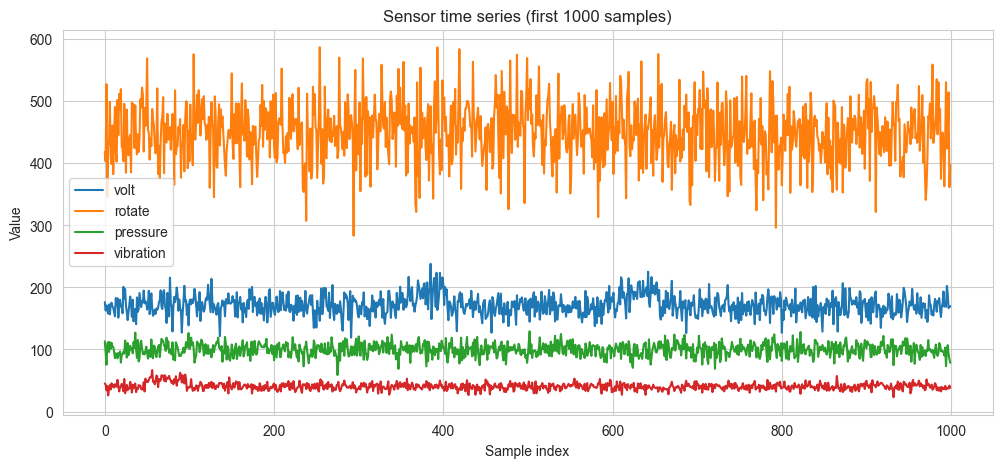

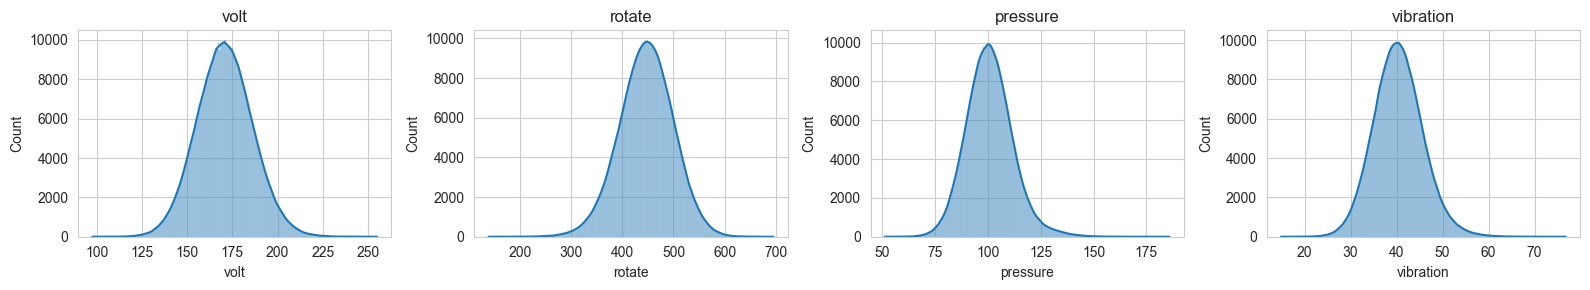

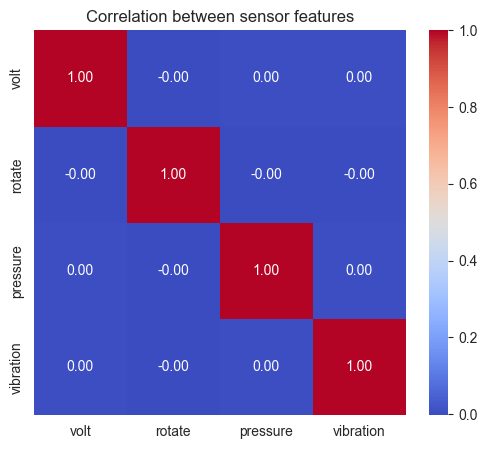

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('whitegrid')

# Preferred sensor names
preferred = ['volt', 'rotate', 'pressure', 'vibration']

# Find which of the preferred names exist in df
sensor_cols = [c for c in preferred if c in df.columns]

# If none of the preferred names exist, try to pick numeric columns automatically
if len(sensor_cols) == 0:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    print("None of the expected sensor columns found:", preferred)
    print("Available numeric columns in dataset:", numeric_cols)
    if len(numeric_cols) == 0:
        raise ValueError("No numeric columns found in the dataframe. Please check your CSV or set DATA_FILE correctly.")
    # Use up to first 4 numeric columns as fallback
    sensor_cols = numeric_cols[:4]
    print("Using fallback sensor columns:", sensor_cols)
else:
    print("Sensor columns used (found):", sensor_cols)


N = min(1000, len(df))
plt.figure(figsize=(12, 5))
for c in sensor_cols:
    plt.plot(df[c].values[:N], label=c)
plt.legend()
plt.title(f"Sensor time series (first {N} samples)")
plt.xlabel("Sample index")
plt.ylabel("Value")
plt.show()

# Distribution plots
n = len(sensor_cols)
fig, axs = plt.subplots(1, n, figsize=(4 * max(1, n), 3))

# Ensure axs is iterable (list)
if n == 1:
    axs = [axs]

for ax, c in zip(axs, sensor_cols):
    sns.histplot(df[c].dropna(), ax=ax, kde=True)
    ax.set_title(c)

plt.tight_layout()
plt.show()



In [11]:
import numpy as np
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

def discover_patterns(sensor_readings):
    df_local = pd.DataFrame(sensor_readings)
    sensor_cols = [c for c in ['volt','rotate','pressure','vibration'] if c in df_local.columns]
    patterns = {'correlations': {}, 'anomalies': {}, 'statistics': {}}
    # correlations
    for i, col1 in enumerate(sensor_cols):
        for col2 in sensor_cols[i+1:]:
            patterns['correlations'][f'{col1}_vs_{col2}'] = round(df_local[col1].corr(df_local[col2]), 3)
    # anomalies by z-score
    for col in sensor_cols:
        z_scores = np.abs(stats.zscore(df_local[col]))
        anomaly_indices = np.where(z_scores > 2.5)[0].tolist()
        if anomaly_indices:
            patterns['anomalies'][col] = {
                'count': len(anomaly_indices),
                'percentage': round(len(anomaly_indices)/len(df_local)*100,2),
                'indices': anomaly_indices[:10],
                'values': [round(v,2) for v in df_local[col].iloc[anomaly_indices[:10]].tolist()]
            }
    # stats
    for col in sensor_cols:
        patterns['statistics'][col] = {
            'mean': round(df_local[col].mean(),2),
            'std': round(df_local[col].std(),2),
            'min': round(df_local[col].min(),2),
            'max': round(df_local[col].max(),2),
            'range': round(df_local[col].max() - df_local[col].min(),2)
        }
    return patterns

def cluster_analysis(sensor_readings, n_clusters=3):
    df_local = pd.DataFrame(sensor_readings)
    sensor_cols = [c for c in ['volt','rotate','pressure','vibration'] if c in df_local.columns]
    X = df_local[sensor_cols].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df_local['cluster'] = kmeans.fit_predict(X_scaled)
    clusters = []
    for i in range(n_clusters):
        cluster_data = df_local[df_local['cluster']==i]
        clusters.append({
            'cluster_id': i,
            'size': len(cluster_data),
            'percentage': round(len(cluster_data)/len(df_local)*100,1),
            'avg_volt': round(cluster_data['volt'].mean(),2) if 'volt' in cluster_data else None,
            'avg_rotate': round(cluster_data['rotate'].mean(),2) if 'rotate' in cluster_data else None,
            'avg_pressure': round(cluster_data['pressure'].mean(),2) if 'pressure' in cluster_data else None,
            'avg_vibration': round(cluster_data['vibration'].mean(),2) if 'vibration' in cluster_data else None
        })
    return clusters, df_local

def temporal_patterns(sensor_readings):
    df_local = pd.DataFrame(sensor_readings)
    sensor_cols = [c for c in ['volt','rotate','pressure','vibration'] if c in df_local.columns]
    trends = {}
    for col in sensor_cols:
        x = np.arange(len(df_local))
        slope, intercept = np.polyfit(x, df_local[col], 1)
        volatility = df_local[col].std() / (df_local[col].mean() if df_local[col].mean()!=0 else 1) * 100
        trends[col] = {
            'trend': 'increasing' if slope > 0.1 else 'decreasing' if slope < -0.1 else 'stable',
            'slope': round(slope,4),
            'volatility_percent': round(volatility,2),
            'volatility_level': 'high' if volatility > 5 else 'medium' if volatility > 2 else 'low'
        }
    return trends

def association_rules(sensor_readings):
    df_local = pd.DataFrame(sensor_readings)
    sensor_cols = [c for c in ['volt','rotate','pressure','vibration'] if c in df_local.columns]
    associations = {}
    for col in sensor_cols:
        q1 = df_local[col].quantile(0.33)
        q2 = df_local[col].quantile(0.67)
        categories = pd.cut(df_local[col], bins=[-np.inf, q1, q2, np.inf], labels=['low','medium','high'])
        associations[col] = categories.value_counts().to_dict()
    return associations

def simulate(scenario='normal', n=12):
    import numpy as np
    if scenario == 'normal':
        readings = [{'volt': float(np.random.normal(170,3)),
                     'rotate': float(np.random.normal(450,15)),
                     'pressure': float(np.random.normal(100,3)),
                     'vibration': float(np.random.normal(40,2))} for _ in range(n)]
    elif scenario == 'warning':
        readings = [{'volt': float(np.random.normal(165,6)),
                     'rotate': float(np.random.normal(480,25)),
                     'pressure': float(np.random.normal(95,6)),
                     'vibration': float(np.random.normal(50,4))} for _ in range(n)]
    else:
        readings = [{'volt': float(np.random.normal(155,8)),
                     'rotate': float(np.random.normal(520,35)),
                     'pressure': float(np.random.normal(85,8)),
                     'vibration': float(np.random.normal(65,6))} for _ in range(n)]
    return readings


In [12]:
# 6) Preprocessing & model helpers (matching API behavior)
import numpy as np, pandas as pd
TIME_STEPS = 12
FEATURE_COLS = ['volt','rotate','pressure','vibration',
                'volt_roll_mean_3h','volt_roll_std_3h',
                'rotate_roll_mean_3h','rotate_roll_std_3h',
                'pressure_roll_mean_3h','pressure_roll_std_3h',
                'vibration_roll_mean_3h','vibration_roll_std_3h',
                'volt_roll_mean_12h','volt_roll_std_12h',
                'rotate_roll_mean_12h','rotate_roll_std_12h',
                'pressure_roll_mean_12h','pressure_roll_std_12h',
                'vibration_roll_mean_12h','vibration_roll_std_12h',
                'error_count']

# Try loading a saved model if exists
import os
MODEL_PATH = 'models/best_model.keras'
SCALER_PATH = 'models/scaler_params.pkl'
model = None
SCALER_MEAN = None
SCALER_STD = None
if os.path.exists(MODEL_PATH):
    try:
        import tensorflow as tf
        model = tf.keras.models.load_model(MODEL_PATH)
        print("Loaded model from", MODEL_PATH)
    except Exception as e:
        print("Failed to load model:", e)

if os.path.exists(SCALER_PATH):
    import pickle
    with open(SCALER_PATH,'rb') as f:
        sp = pickle.load(f)
        SCALER_MEAN = np.array(sp['mean'])
        SCALER_STD = np.array(sp['std'])
        print("Loaded scaler params from", SCALER_PATH)

# fallback approximate scaler
if SCALER_MEAN is None or SCALER_STD is None:
    SCALER_MEAN = np.array([170.5, 446.7, 100.3, 40.2] + [170.5, 2.0, 446.7, 10.0, 100.3, 2.0, 40.2, 1.0] * 2 + [0.5])
    SCALER_STD = np.array([10.2, 45.3, 9.8, 5.1] + [10.2, 3.0, 45.3, 15.0, 9.8, 3.0, 5.1, 2.0] * 2 + [1.5])

def preprocess_sensor_data(sensor_readings):
    df_local = pd.DataFrame(sensor_readings)
    required = ['volt','rotate','pressure','vibration']
    for col in required:
        if col not in df_local.columns:
            raise ValueError(f"Missing required column: {col}")
    # rolling features 3h and 12h
    for col in ['volt','rotate','pressure','vibration']:
        df_local[f'{col}_roll_mean_3h'] = df_local[col].rolling(window=3, min_periods=1).mean()
        df_local[f'{col}_roll_std_3h'] = df_local[col].rolling(window=3, min_periods=1).std().fillna(0)
    for col in ['volt','rotate','pressure','vibration']:
        df_local[f'{col}_roll_mean_12h'] = df_local[col].rolling(window=min(12,len(df_local)), min_periods=1).mean()
        df_local[f'{col}_roll_std_12h'] = df_local[col].rolling(window=min(12,len(df_local)), min_periods=1).std().fillna(0)
    df_local['error_count'] = 0
    features = df_local[FEATURE_COLS].values
    features = (features - SCALER_MEAN) / SCALER_STD
    return features

def predict_failure(sensor_readings):
    if model is None:
        raise Exception("No model loaded. Train a model first or place models/best_model.keras in folder.")
    features = preprocess_sensor_data(sensor_readings)
    if len(features) < TIME_STEPS:
        last_reading = features[-1:].copy()
        padding = np.repeat(last_reading, TIME_STEPS - len(features), axis=0)
        features = np.vstack([padding, features])
    sequence = features[-TIME_STEPS:]
    sequence = sequence.reshape(1, TIME_STEPS, len(FEATURE_COLS))
    prediction = model.predict(sequence, verbose=0)
    if prediction.ndim == 2 and prediction.shape[1] == 1:
        probability = float(prediction[0][0])
    else:
        probability = float(prediction[0])
    return probability

def get_risk_assessment(probability):
    prob_percent = probability * 100
    if probability > 0.8:
        risk_level = 'CRITICAL'; action = 'URGENT: Schedule immediate maintenance within 24-48 hours'
    elif probability > 0.5:
        risk_level = 'HIGH'; action = 'Schedule maintenance within 7 days'
    elif probability > 0.3:
        risk_level = 'MEDIUM'; action = 'Monitor closely'
    else:
        risk_level = 'LOW'; action = 'Machine operating normally'
    return {'probability': round(prob_percent,2), 'risk_level': risk_level, 'action': action}


Loaded model from models/best_model.keras
Loaded scaler params from models/scaler_params.pkl


Using sensor columns: ['volt', 'rotate', 'pressure', 'vibration']

=== Running discover_patterns() ===
{
  "correlations": {
    "volt_vs_rotate": -0.002,
    "volt_vs_pressure": 0.002,
    "volt_vs_vibration": 0.002,
    "rotate_vs_pressure": -0.001,
    "rotate_vs_vibration": -0.003,
    "pressure_vs_vibration": 0.001
  },
  "anomalies": {
    "volt": {
      "count": 11718,
      "percentage": 1.34,
      "indices": [
        77,
        80,
        91,
        126,
        136,
        281,
        291,
        359,
        370,
        385
      ],
      "values": [
        215.66,
        129.02,
        127.16,
        213.79,
        121.5,
        130.22,
        119.06,
        216.96,
        211.15,
        237.94
      ]
    },
    "rotate": {
      "count": 12475,
      "percentage": 1.42,
      "indices": [
        238,
        254,
        294,
        393,
        419,
        583,
        793,
        1099,
        1338,
        1347
      ],
      "values": [
       

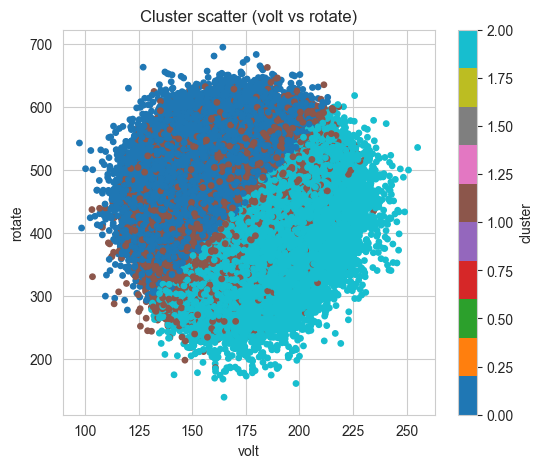

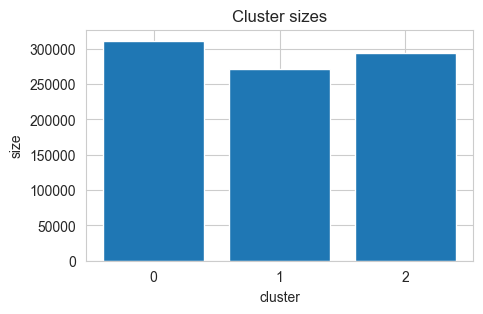


=== Time-series + trend summary ===


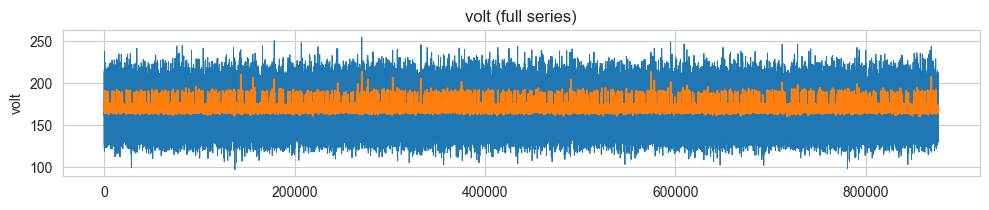

  volt: trend=stable, slope=-0.0, volatility=9.08%


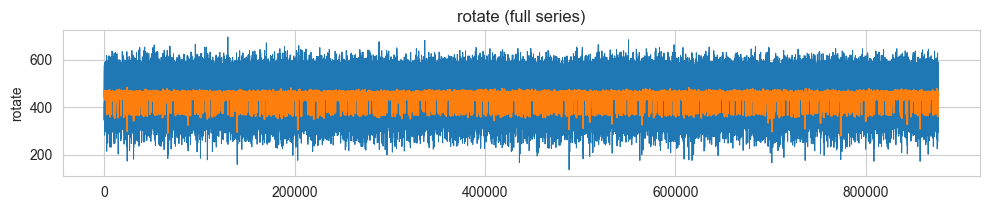

  rotate: trend=stable, slope=0.0, volatility=11.79%


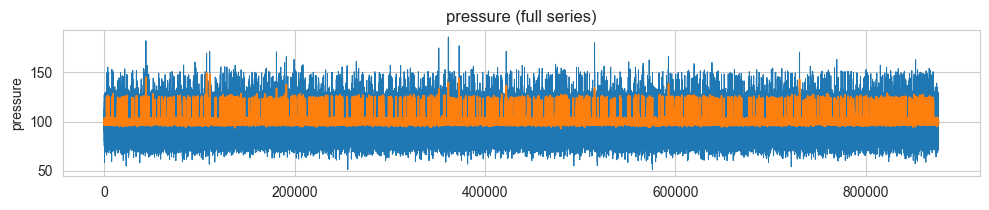

  pressure: trend=stable, slope=0.0, volatility=10.95%


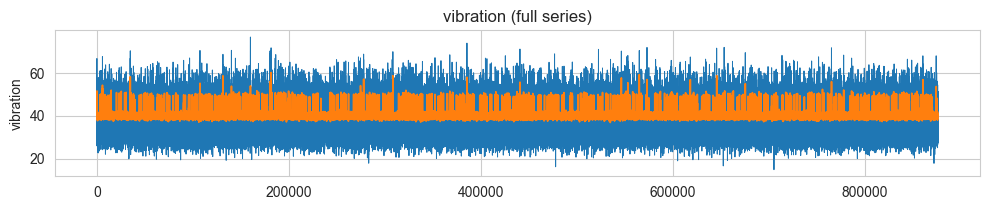

  vibration: trend=stable, slope=-0.0, volatility=13.3%

=== Full mining finished ===


In [13]:

import json
import matplotlib.pyplot as plt
import numpy as np

# choose sensor columns (prefer expected names, else fallback to first numeric cols)
preferred = ['volt', 'rotate', 'pressure', 'vibration']
sensor_cols = [c for c in preferred if c in df.columns]

if len(sensor_cols) == 0:
    # fallback: pick up to 4 numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) == 0:
        raise ValueError("No numeric columns found in dataframe to run mining. Check your CSV or column names.")
    sensor_cols = numeric_cols[:4]
    print("Using fallback numeric sensor columns:", sensor_cols)
else:
    print("Using sensor columns:", sensor_cols)

# build sensor_readings list-of-dicts
sensor_readings = df[sensor_cols].to_dict('records')
if len(sensor_readings) == 0:
    raise ValueError("Dataframe appears empty. Cannot run mining on 0 rows.")

# ------------- discover_patterns -------------
print("\n=== Running discover_patterns() ===")
try:
    patterns = discover_patterns(sensor_readings)
    print(json.dumps(patterns, indent=2))
except Exception as e:
    print("discover_patterns() failed:", e)
    patterns = None

# ------------- cluster_analysis -------------
print("\n=== Running cluster_analysis() ===")
try:
    clusters, clustered_df = cluster_analysis(sensor_readings, n_clusters=3)
    print(json.dumps(clusters, indent=2))
except Exception as e:
    print("cluster_analysis() failed:", e)
    clusters = None
    clustered_df = None

# ------------- temporal_patterns -------------
print("\n=== Running temporal_patterns() ===")
try:
    trends = temporal_patterns(sensor_readings)
    print(json.dumps(trends, indent=2))
except Exception as e:
    print("temporal_patterns() failed:", e)
    trends = None

# ------------- association_rules -------------
print("\n=== Running association_rules() ===")
try:
    assocs = association_rules(sensor_readings)
    print(json.dumps(assocs, indent=2))
except Exception as e:
    print("association_rules() failed:", e)
    assocs = None

# ------------- Plots -------------
# Cluster scatter (volt vs rotate) and cluster sizes
if clustered_df is not None:
    if 'volt' in clustered_df.columns and 'rotate' in clustered_df.columns:
        plt.figure(figsize=(6,5))
        sc = plt.scatter(clustered_df['volt'], clustered_df['rotate'], c=clustered_df['cluster'], cmap='tab10', s=15)
        plt.xlabel('volt'); plt.ylabel('rotate'); plt.title('Cluster scatter (volt vs rotate)')
        plt.colorbar(sc, label='cluster')
        plt.show()
    else:
        print("Skipping volt-vs-rotate scatter: columns not found in clustered_df.")

    # cluster sizes bar chart
    try:
        sizes = clustered_df['cluster'].value_counts().sort_index()
        plt.figure(figsize=(5,3))
        plt.bar(sizes.index.astype(str), sizes.values)
        plt.xlabel('cluster'); plt.ylabel('size'); plt.title('Cluster sizes')
        plt.show()
    except Exception as e:
        print("Failed to plot cluster sizes:", e)

# Time-series sample and trend slopes (small visual summary)
print("\n=== Time-series + trend summary ===")
try:
    for c in sensor_cols:
        plt.figure(figsize=(10,2.2))
        plt.plot(df[c].values, linewidth=0.7)
        # show rolling mean for quick visual
        if len(df) > 5:
            roll = pd.Series(df[c]).rolling(window=min(50, max(2, len(df)//20))).mean()
            plt.plot(roll.values, linewidth=1.2, label='rolling mean')
        plt.title(f"{c} (full series)")
        plt.ylabel(c)
        plt.tight_layout()
        plt.show()
        # print small trend summary if available from trends
        if trends and c in trends:
            t = trends[c]
            print(f"  {c}: trend={t.get('trend')}, slope={t.get('slope')}, volatility={t.get('volatility_percent')}%")
except Exception as e:
    print("Time-series plotting failed:", e)

print("\n=== Full mining finished ===")


Using sensor columns: ['volt', 'rotate', 'pressure', 'vibration']
Sequences shape: (876089, 12, 4) (n_samples, time_steps, n_features=4)
Target distribution (counts): {np.int64(0): np.int64(788479), np.int64(1): np.int64(87610)}
Train/test shapes: (700871, 12, 4) (175218, 12, 4) (700871,) (175218,)
Using class_weight: {0: np.float64(0.555556348221179), 1: np.float64(4.999935795000571)}



C:\Users\SHREYA\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,777 (77.25 KB)

 Trainable params: 19,777 (77.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
21903/21903 - 141s - 6ms/step - accuracy: 0.8967 - loss: 0.6224 - val_accuracy: 0.8991 - val_loss: 0.6127
Epoch 2/5
21903/21903 - 137s - 6ms/step - accuracy: 0.9038 - loss: 0.6211 - val_accuracy: 0.9072 - val_loss: 0.5957
Epoch 3/5
21903/21903 - 146s - 7ms/step - accuracy: 0.9042 - loss: 0.6207 - val_accuracy: 0.8924 - val_loss: 0.6063
Epoch 4/5
21903/21903 - 151s - 7ms/step - accuracy: 0.9038 - loss: 0.6206 - val_accuracy: 0.9019 - val_loss: 0.6124
Epoch 5/5
21903/21903 - 144s - 7ms/step - accuracy: 0.9043 - loss: 0.6205 - val_accuracy: 0.9001 - val_loss: 0.5942

Training finished. Best model saved to: models\best_model.keras
Scaler parameters saved to: models\scaler_params.pkl


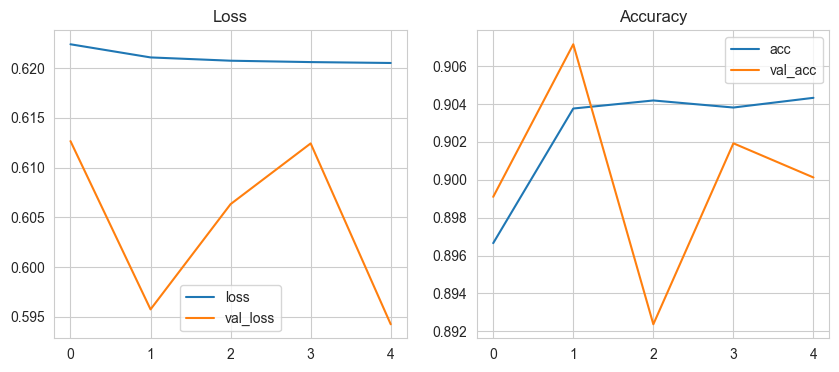

In [14]:
# 8) Robust LSTM training cell (synthetic-target demo)
import os
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Settings
TIME_STEPS = 12
EPOCHS = 5
BATCH_SIZE = 32
MODEL_DIR = "models"
MODEL_PATH = os.path.join(MODEL_DIR, "best_model.keras")
SCALER_PATH = os.path.join(MODEL_DIR, "scaler_params.pkl")

# 1) choose sensor columns (preferred order)
preferred = ['volt', 'rotate', 'pressure', 'vibration']
sensor_cols = [c for c in preferred if c in df.columns]
if len(sensor_cols) == 0:
    # fallback: use up to 4 numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) == 0:
        raise ValueError("No numeric columns found. Check your CSV or column names.")
    sensor_cols = numeric_cols[:4]
    print("Using fallback numeric columns:", sensor_cols)
else:
    print("Using sensor columns:", sensor_cols)

# 2) Prepare X (impute) and sequences
X_raw = df[sensor_cols].values.astype(float)
imp = SimpleImputer(strategy='median')
X_imputed = imp.fit_transform(X_raw)

def make_sequences(X, time_steps=TIME_STEPS):
    seqs = []
    for i in range(len(X) - time_steps + 1):
        seqs.append(X[i:i+time_steps])
    return np.array(seqs)

seqs = make_sequences(X_imputed, TIME_STEPS)
if seqs.size == 0:
    raise ValueError(f"Not enough rows ({len(df)}) to form any sequence with TIME_STEPS={TIME_STEPS}.")

n_samples, ts, n_feats = seqs.shape
print(f"Sequences shape: {seqs.shape} (n_samples, time_steps, n_features={n_feats})")

# 3) Build synthetic target: next-step vibration > 90th percentile (requires 'vibration' column)
if 'vibration' not in df.columns:
    raise ValueError("Column 'vibration' is required to create the synthetic target. Rename/prepare your CSV accordingly.")

threshold = np.percentile(df['vibration'].values, 90)
y_full = []
for i in range(TIME_STEPS - 1, len(df)):
    next_idx = i + 1
    if next_idx < len(df):
        y_full.append(int(df['vibration'].iloc[next_idx] > threshold))
    else:
        y_full.append(0)
y = np.array(y_full)[:len(seqs)]
print("Target distribution (counts):", dict(zip(*np.unique(y, return_counts=True))))

# 4) Scale features (fit scaler on flattened sequences)
flat = seqs.reshape(-1, n_feats)
scaler = StandardScaler()
flat_scaled = scaler.fit_transform(flat)
seqs_scaled = flat_scaled.reshape(n_samples, ts, n_feats)

# 5) Train-test split
stratify_arg = y if len(np.unique(y)) > 1 else None
X_train, X_test, y_train, y_test = train_test_split(seqs_scaled, y, test_size=0.2, random_state=42, stratify=stratify_arg)
print("Train/test shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Check for degenerate target (all zeros or ones)
if len(np.unique(y_train)) == 1:
    print("Target is degenerate in training set (all same class). Aborting training.")
    print("Target distribution (full):", dict(zip(*np.unique(y, return_counts=True))))
else:
    # 6) Compute class weights if highly imbalanced
    classes = np.unique(y_train)
    if len(classes) > 1:
        class_weight = dict(enumerate(compute_class_weight('balanced', classes=classes, y=y_train)))
        print("Using class_weight:", class_weight)
    else:
        class_weight = None

    # 7) Build model
    tf.keras.backend.clear_session()
    model = Sequential([
        LSTM(64, input_shape=(TIME_STEPS, n_feats)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    # 8) Callbacks
    os.makedirs(MODEL_DIR, exist_ok=True)
    early = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    checkpoint = ModelCheckpoint(MODEL_PATH, monitor='val_loss', save_best_only=True, save_weights_only=False)

    # 9) Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early, checkpoint],
        class_weight=class_weight,
        verbose=2
    )

    # 10) Save scaler params (mean & std)
    import pickle
    with open(SCALER_PATH, 'wb') as f:
        pickle.dump({'mean': scaler.mean_.tolist(), 'std': scaler.scale_.tolist()}, f)

    print(f"\nTraining finished. Best model saved to: {MODEL_PATH}")
    print(f"Scaler parameters saved to: {SCALER_PATH}")

    # 11) Plot training curves
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend(); plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(history.history.get('accuracy', []), label='acc')
    plt.plot(history.history.get('val_accuracy', []), label='val_acc')
    plt.legend(); plt.title('Accuracy')
    plt.show()


In [16]:
# Safe auto-detecting prediction cell: adapts input features to model's expected input_dim
print("=== Auto-detecting model input shape and predicting ===")
import numpy as np
import os
import pickle

try:
    # 0) Check model present
    if 'model' not in globals() or model is None:
        raise ValueError("Model is not loaded. Train the model first or load models/best_model.keras into 'model' variable.")

    # 1) Get required columns and sensor list
    required_raw = ['volt', 'rotate', 'pressure', 'vibration']
    if 'df' not in globals():
        raise ValueError("Dataframe 'df' not found. Load your CSV first.")
    # Build list of raw sensor readings from df (fallback to numeric if names differ)
    if all(c in df.columns for c in required_raw):
        raw_cols = required_raw
    else:
        # fallback: pick first 4 numeric columns
        numeric = df.select_dtypes(include=[np.number]).columns.tolist()
        if len(numeric) < 4:
            raise ValueError(f"Cannot find 4 numeric columns in df. Found: {numeric}")
        raw_cols = numeric[:4]
        print("Warning: Using fallback raw columns:", raw_cols)

    # 2) Ensure we have latest readings to predict on
    sr = df[raw_cols].to_dict('records')
    if len(sr) == 0:
        raise ValueError("No sensor readings available in dataframe.")
    if len(sr) < 12:
        # pad with last reading
        last = sr[-1]
        sr = [last] * (12 - len(sr)) + sr
    sensor_last_raw = sr[-12:]  # list of 12 dicts with raw_cols keys

    # 3) Inspect model input shape (expecting something like (None, TIME_STEPS, input_dim))
    model_input_shape = None
    try:
        model_input_shape = model.input_shape  # tuple
    except Exception:
        # fallback for some saved models
        model_input_shape = getattr(model, 'layers')[0].input_shape if hasattr(model, 'layers') else None

    if not model_input_shape:
        raise ValueError("Unable to determine model.input_shape. Model: {}".format(type(model)))

    # Normalize shape: can be (None, 12, 4) or (1, 12, 4)
    if isinstance(model_input_shape, list):
        model_input_shape = model_input_shape[0]
    _, time_steps_expected, input_dim_expected = model_input_shape

    print(f"Model expects time_steps={time_steps_expected}, input_dim={input_dim_expected}")

    # 4) Prepare input depending on expected input_dim
    if input_dim_expected == len(required_raw) or input_dim_expected == len(raw_cols):
        # model expects just the raw 4 features per timestep
        # build numpy array shape (1, time_steps_expected, input_dim_expected)
        arr = np.array([[ [r[c] for c in raw_cols] for r in sensor_last_raw ]], dtype=float)  # shape (1,12,4)
        # If time_steps mismatch, pad/trim along time axis
        if arr.shape[1] < time_steps_expected:
            pad_count = time_steps_expected - arr.shape[1]
            pad = np.repeat(arr[:, -1:, :], pad_count, axis=1)
            arr = np.concatenate([pad, arr], axis=1)
        elif arr.shape[1] > time_steps_expected:
            arr = arr[:, -time_steps_expected:, :]

        # 4.a) Scale features if scaler params available (models/scaler_params.pkl)
        scaler_mean = None; scaler_std = None
        if os.path.exists('models/scaler_params.pkl'):
            try:
                with open('models/scaler_params.pkl', 'rb') as f:
                    sp = pickle.load(f)
                    # saved mean/std may be for full-flat scaler or partial; try to extract first n features
                    mean = np.array(sp.get('mean'))
                    std = np.array(sp.get('std'))
                    if mean.size >= arr.shape[2] and std.size >= arr.shape[2]:
                        scaler_mean = mean[:arr.shape[2]]
                        scaler_std = std[:arr.shape[2]]
            except Exception:
                pass

        if scaler_mean is not None and scaler_std is not None:
            # apply scaling per-feature
            arr_flat = arr.reshape(-1, arr.shape[2])
            arr_flat = (arr_flat - scaler_mean) / scaler_std
            arr = arr_flat.reshape(1, arr.shape[1], arr.shape[2])
        else:
            # fallback: standardize on-the-fly using training-like scaling (fit on df raw_cols)
            from sklearn.preprocessing import StandardScaler
            sc = StandardScaler()
            sample_flat = df[raw_cols].astype(float).values
            try:
                sc.fit(sample_flat)
                arr_flat = arr.reshape(-1, arr.shape[2])
                arr_flat = sc.transform(arr_flat)
                arr = arr_flat.reshape(1, arr.shape[1], arr.shape[2])
            except Exception:
                # leave unscaled if scaling fails
                pass

        # 4.b) Predict
        pred = model.predict(arr, verbose=0)
        probability = float(pred.flatten()[0])

    else:
        # model expects more features (likely the 21-feature pipeline)
        # use existing preprocess_sensor_data() which produces the FEATURE_COLS-length vectors
        try:
            features = preprocess_sensor_data(sensor_last_raw)
        except Exception as e:
            raise ValueError("preprocess_sensor_data failed: " + str(e))

        # ensure we have time_steps_expected rows
        if features.shape[0] < time_steps_expected:
            last_row = features[-1:].copy()
            pad = np.repeat(last_row, time_steps_expected - features.shape[0], axis=0)
            features = np.vstack([pad, features])
        seq = features[-time_steps_expected:].reshape(1, time_steps_expected, -1)
        pred = model.predict(seq, verbose=0)
        probability = float(pred.flatten()[0])

    # 5) Print result + risk assessment
    print("Predicted failure probability (0-1):", round(probability, 5))
    try:
        print("Risk assessment:", get_risk_assessment(probability))
    except Exception:
        # fallback simple thresholds
        p = probability
        lvl = "CRITICAL" if p>0.8 else "HIGH" if p>0.5 else "MEDIUM" if p>0.3 else "LOW"
        print(f"Risk level (approx): {lvl}")

except Exception as e:
    print("Prediction not available:", repr(e))


=== Auto-detecting model input shape and predicting ===
Model expects time_steps=12, input_dim=4
Predicted failure probability (0-1): 0.42647
Risk assessment: {'probability': 42.65, 'risk_level': 'MEDIUM', 'action': 'Monitor closely'}
